In [1]:
from pathlib import Path
import pandas as pd
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import numpy as np

from transformers import BertTokenizer
from transformers import BertModel, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import DistilBertModel, AdamW
from transformers import BertForSequenceClassification
import random

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

import os
os.chdir('..')

from src.data import LexDataset, read_corpus_split

In [2]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [3]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_metric(preds, labels):
    pred_flat = preds.flatten()
    labels_flat = labels.flatten()
    return mean_absolute_error(pred_flat, labels_flat)

In [4]:

def train(loader):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_train_loss = 0
    model.train()

    for step, batch in enumerate(loader):

        # if step % 40 == 0 and not step == 0:
        #     elapsed = format_time(time.time() - t0)
        #     print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_loader), elapsed))

        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        # Clear gradients
        model.zero_grad()        

        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Compute gradients
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)            

    print("")
    print("  Average training loss: {0:.6f}".format(avg_train_loss))
    
def evaluate(loader):
    print("")
    print("Running Validation...")
    
    model.eval()
    
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    
    all_logits = []
    training_stats = []
    # Evaluate data for one epoch
    ix = 0
    for batch in loader:
        ix += 1
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)
        
        with torch.no_grad():        

            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        val_metric = flat_metric(logits, label_ids)
        total_eval_accuracy += val_metric
        all_logits.append(logits.flatten()[0])

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    print("  Metric: {0:.6f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(val_loader)
    
    print("  Validation Loss: {0:.6f}".format(avg_val_loss))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
        }
    )
    
    return training_stats, all_logits


In [ ]:
import random
import numpy as np
from transformers import get_linear_schedule_with_warmup

epochs = 20
seed_val = 42
results_window = {}
for window_x in [0, 1, 2, 3, 4, 5]:
    print('Window size of ', window_x)
    data_texts, data_corpus, data_labels, sentence_raw, target_words, positions = read_corpus_split('data/raw/lcp_single_train.tsv',
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    torch.cuda.manual_seed_all(seed_val)

    kf = StratifiedKFold(8, shuffle=True, random_state=0)

    history_preds = []
    history_samples = []
    history_input = []
    history_target = []
    history_index = []
    history_labels = []
    history_occur_text = []
    history_occur_target = []
    ix_fold = 0

    for train_index, val_index in kf.split(data_texts, data_corpus):
        print('Starting a new fold ...')

        train_texts, train_labels, train_positions, train_target_words = data_texts[train_index], data_labels[train_index], positions[train_index], target_words[train_index]
        val_texts, val_labels, val_positions, val_target_words = data_texts[val_index], data_labels[val_index], positions[val_index], target_words[val_index]

        train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
        train_dataset = LexDataset(train_encodings, train_labels, train_positions)

        val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
        val_dataset = LexDataset(val_encodings, val_labels, val_positions)

        train_loader = DataLoader(train_dataset, batch_size=16)
        val_loader = DataLoader(val_dataset, batch_size=1)
        
        all_text = ' '.join(train_texts)
        occurence_text = [all_text.count(w) for w in val_target_words]
        
        occurence_target = [train_target_words.tolist().count(w) for w in val_target_words]
        
        device = torch.device("cuda:1")
        
        model = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased", 
            num_labels = 1, 
            output_attentions = False, 
            output_hidden_states = False, 
        )
        model.cuda(1)

        optimizer = AdamW(model.parameters(),
                          lr = 2e-5, 
                          eps = 1e-8
                        )
        device = torch.device("cuda:1")

        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)

        for epoch_i in range(0, epochs):
            train(train_loader)
            training_stats, all_logits = evaluate(val_loader)

        history_labels.extend(val_labels)
        history_preds.extend(all_logits)
        history_samples.extend(val_texts)
        history_input.extend(sentence_raw[val_index])
        history_target.extend(target_words[val_index])
        history_index.extend(([ix_fold] * len(val_index)))
        history_occur_text.extend(occurence_text)
        history_occur_target.extend(occurence_target)
        ix_fold += 1

        print("")
        print("Training complete!")
        
    results = pd.DataFrame()
    results['samples'] = history_samples
    results['preds'] =history_preds
    results['true_val'] =history_labels
    results['raw'] = history_input
    results['raw'] = results['raw'].astype(str)
    results['target'] = history_target
    results['index'] = history_index
    results['occur_text'] = history_occur_text
    results['occur_target'] = history_occur_target
    
    results_window[window_x] = results

Window size of  0
Starting a new fold ...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.015953

Running Validation...
  Metric: 0.320346
  Validation Loss: 0.117848

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.022643

Running Validation...
  Metric: 0.266512
  Validation Loss: 0.083798

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.019224

Running Validation...
  Metric: 0.241277
  Validation Loss: 0.069118

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.014161

Running Validation...
  Metric: 0.214745
  Validation Loss: 0.054145

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.012617

Running Validation...
  Metric: 0.226894
  Validation Loss: 0.060581

======== Epoch 6 / 20 ========
Training...

  Average training loss: 0.011360

Running Validation...
  Metric: 0.197874
  Validation Loss: 0.047161

======== Epoch 7 / 20 ========
Training...

  Average training loss: 0.011052

Running Validation...
  Me

In [11]:
for window_ix in results_window:
    results_window[window_ix]['mae'] = results_window[window_ix].apply(lambda x: mean_absolute_error([x.preds],[x.true_val]), axis=1)
    results_window[window_ix]['mse'] = results_window[window_ix].apply(lambda x: mean_squared_error([x.preds],[x.true_val]), axis=1)
    results_window[window_ix]['discrete_occur'] = results_window[window_ix].apply(lambda x: x.occur_target if (x.occur_target == 0 or x.occur_target == 1) else 2, axis=1)
    

In [13]:
results_window[5]

,samples,preds,true_val,raw,target,index,occur_text,occur_target,mae,mse,discrete_occur
0,and six daughters; but his brothers didn't hav...,0.088512,0.150000,Shimei had sixteen sons and six daughters; but...,brothers,0,7,2,0.061488,0.003781,2
1,"the lake that burns with fire and sulfur, whic...",0.193253,0.133333,"But for the cowardly, unbelieving, sinners, ab...",fire,0,25,4,0.059919,0.003590,2
2,"of suffering, and acquainted with disease.",0.171035,0.125000,"He was despised, and rejected by men; a man of...",disease,0,40,4,0.046035,0.002119,2
3,"another comes in his own name, you will receiv...",0.164845,0.176471,"If another comes in his own name, you will rec...",name,0,25,3,0.011626,0.000135,2
4,the earth; Yahweh is his name.,0.262728,0.208333,"It is he who builds his rooms in the heavens, ...",name,0,25,3,0.054395,0.002959,2
...,...,...,...,...,...,...,...,...,...,...,...
7227,"this most appalling form of totalitarianism, a...",0.280678,0.573529,"Well, I believe that the main difficulty in th...",totalitarianism,7,0,0,0.292852,0.085762,0
7228,in the implementation of the Leonardo programm...,0.399483,0.593750,I need only remind the House of the occurrence...,Leonardo,7,1,0,0.194267,0.037740,0
7229,"the chief engineer, to the boatswain, to the m...",0.275798,0.650000,I think it is very important to add that more ...,boatswain,7,0,0,0.374202,0.140027,0
7230,"and unprecedented consequences, and new jurisp...",0.260539,0.671875,The struggle against global Islamic terrorism ...,jurisprudence,7,0,0,0.411336,0.169197,0


In [14]:
for window_ix in results_window:
    print('Window of', window_ix)

    mae = results_window[window_ix].groupby(['index']).mae.mean()
    mse = results_window[window_ix].groupby(['index']).mse.mean()
    #r_2 = results_window[window_ix].groupby(['index']).
    
    print('MAE --- Mean:', round(np.mean(mae), 4), ' Std:', round(np.std(mae), 4))
    print('MSE --- Mean:', round(np.mean(mse), 4), ' Std:', round(np.std(mse), 4))
    #print('R2  --- Mean:', round(np.mean(r_2), 4), ' Std:', round(np.std(r_2), 4))
    print()


Window of 0
MAE --- Mean: 0.0718  Std: 0.0027
MSE --- Mean: 0.0085  Std: 0.0007

Window of 1
MAE --- Mean: 0.0756  Std: 0.0027
MSE --- Mean: 0.0097  Std: 0.0009

Window of 2
MAE --- Mean: 0.0793  Std: 0.0032
MSE --- Mean: 0.011  Std: 0.001

Window of 3
MAE --- Mean: 0.0905  Std: 0.0179
MSE --- Mean: 0.0157  Std: 0.0087

Window of 4
MAE --- Mean: 0.0888  Std: 0.0055
MSE --- Mean: 0.0137  Std: 0.0015

Window of 5
MAE --- Mean: 0.0914  Std: 0.005
MSE --- Mean: 0.0143  Std: 0.0013



In [17]:
for window_ix in results_window:
    df_temp = results_window[window_ix].groupby(['index', 'discrete_occur']).agg({'mse': 'mean',
                                                                         'mae': 'mean'}).reset_index()
    df_temp = df_temp.groupby('discrete_occur').agg({'mse': ['mean', 'std'],
                                          'mae': ['mean', 'std']}).reset_index()
    df_temp.columns = ['_'.join(col).strip('_') for col in df_temp.columns]
    print('Window of', window_ix)
    print(df_temp)
    print()

Window of 0
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  0.008812  0.000606  0.072836  0.002404
1               1  0.010205  0.001394  0.077206  0.005709
2               2  0.007905  0.000990  0.069754  0.004057

Window of 1
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  0.009973  0.001016  0.075946  0.001757
1               1  0.010327  0.001293  0.077419  0.004650
2               2  0.009393  0.001491  0.074841  0.005250

Window of 2
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  0.012257  0.001628  0.082450  0.003309
1               1  0.011527  0.001732  0.081327  0.005620
2               2  0.010255  0.001343  0.077231  0.005096

Window of 3
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  0.016371  0.004985  0.094101  0.010960
1               1  0.016060  0.009485  0.091190  0.019704
2               2  0.015287  0.011311  0.088595  0.023052

Window of 4
   discr

In [16]:
import spacy

nlp = spacy.load("en_core_web_sm")
def find_pos(sentence, ref):
    doc = nlp(sentence)
    for token in doc:
        if token.text == ref:
            return token.pos_

In [13]:
results = pd.DataFrame()
results['samples'] = history_samples
results['metrics'] = history_logits
results['raw'] = history_input
results['raw'] = results['raw'].astype(str)
results['target'] = history_target

In [59]:
results['index'] = history_index

In [14]:
from pandarallel import pandarallel
pandarallel.initixalize()


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [15]:
results['pos_label'] =  results.parallel_apply(lambda x: find_pos(x.raw, x.target), axis=1)

In [51]:
results.head(3)

,samples,metrics,raw,target,pos_label,index
0,"with your brothers, the prophets,",0.235160,I am a fellow bondservant with you and with yo...,brothers,NOUN,0
1,The sons of Perez:,0.095476,"The sons of Perez: Hezron, and Hamul.",sons,NOUN,0
2,The days of our,0.188235,"The days of our years are seventy, or even by ...",days,NOUN,0


/home/krivas/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


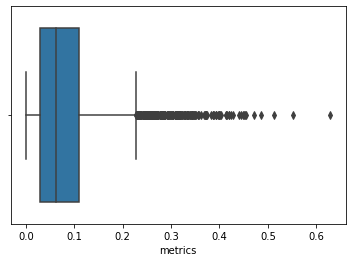

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.boxplot(results.metrics)
plt.show()

In [19]:
np.mean(results.metrics)

0.07860309877731128

## Results

- mean and std with 5 Folds

In [20]:
np.mean([metric['Valid. Accur.'] for metric in history_metrics if metric['epoch'] == epochs]), np.std([metric['Valid. Accur.'] for metric in history_metrics if metric['epoch'] == epochs])


(0.07860287763834664, 0.0013531799355138525)

- Evaluate on 1 occurence

In [72]:
df_temp = results.groupby('target')[['metrics']].count().reset_index()
df_temp.columns = ['target', 'count']
results_one = pd.merge(results, df_temp.loc[df_temp['count'] == 1], on='target')
df_temp = results_one.groupby(['index'])[['metrics']].mean()
print('With shape of ', results_one.shape)
np.mean(df_temp['metrics']), np.std(df_temp['metrics'])

With shape of  (1704, 7)


(0.08478344947012915, 0.003118498473680763)

In [73]:
df_temp = results.groupby('target')[['metrics']].count().reset_index()
df_temp.columns = ['target', 'count']
results_many = pd.merge(results, df_temp.loc[df_temp['count'] > 1], on='target')
df_temp = results_many.groupby(['index'])[['metrics']].mean()
print('With shape of ', results_many.shape)
np.mean(df_temp['metrics']), np.std(df_temp['metrics'])

With shape of  (5525, 7)


(0.07665920874978771, 0.0021418881362506303)

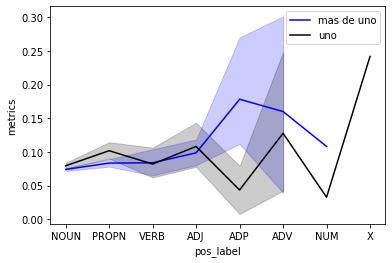

In [78]:
p1 = sns.lineplot(x='pos_label', y='metrics', data=results_many.loc[results_many.pos_label.notnull()], ci=98, markers='o', color='blue')
p2 = sns.lineplot(x='pos_label', y='metrics', data=results_one.loc[results_one.pos_label.notnull()], ci=98, markers='o', color='black')
plt.legend(['mas de uno', 'uno'])
plt.show()

- Eval on pos tag

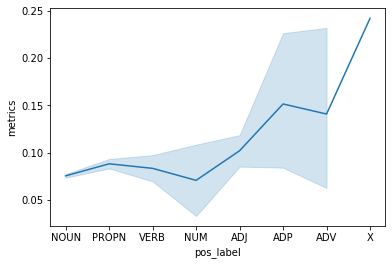

In [25]:
sns.lineplot(x='pos_label', y='metrics', data=results.loc[results.pos_label.notnull()], ci=98, markers='o')
plt.show()